In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from itertools import combinations
import random
from tqdm import tqdm
import joblib 
import os  

# Create "Models" directory if it doesn't exist
if not os.path.exists('Models'):
    os.makedirs('Models')


In [3]:
# Load the transformed exoplanet data
exoplanet_data_transformed = pd.read_csv('Exoplanet_Data_Transformed.csv')

# Access the 'Planet Name' column
planet_names = exoplanet_data_transformed['Planet Name']


In [4]:
# Function to remove low variance features
def filter_low_variance_features(data, threshold=0.01):
    variances = data.var()
    low_variance_features = variances[variances < threshold].index.tolist()
    print("Low variance features removed:", low_variance_features)
    return data.drop(columns=low_variance_features)

# Filter out low variance features
scaled_data_df = filter_low_variance_features(exoplanet_data_transformed.drop(columns=['Planet Name']), threshold=0.01)


Low variance features removed: ['Number of Duplicated Measurements', 'Planet Radius Limit', 'Star Mass Limit', 'Star Radius Limit']


In [5]:
# Define optimal_k
optimal_k = 4

# Clustering function
def perform_clustering(data, optimal_k):
    kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(data)
    unique_labels = np.unique(kmeans.labels_)
    
    if len(unique_labels) < 2:
        print("Only one cluster found. Returning score of -1.")
        return kmeans, -1

    score = silhouette_score(data, kmeans.labels_)
    return kmeans, score

def variance_threshold_clustering(data):
    selector = VarianceThreshold(threshold=0.1)
    high_variance_features = selector.fit_transform(data)
    features_retained = data.columns[selector.get_support(indices=True)].tolist()
    print("Features retained based on variance threshold:", features_retained)
    variance_reduced_df = data[features_retained]
    return perform_clustering(variance_reduced_df, optimal_k)

def correlation_analysis_clustering(data):
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    print("Features to drop due to high correlation:", to_drop)
    corr_reduced_df = data.drop(columns=to_drop)
    return perform_clustering(corr_reduced_df, optimal_k)

# Try to find the optimal features by iterating and randomly removing. Compare score to monitor for improvement
def random_feature_removal(data, optimal_k, patience=20, min_features=7, initial_n_combinations=20):
    best_score = -1
    best_features = data.columns.tolist()
    no_improvement_count = 0
    current_features = best_features.copy()
    iteration = 0

    while len(current_features) > min_features:
        iteration += 1
        
        if iteration % 5 == 0:
            print(f"Iteration {iteration}: Trying random combinations with {len(current_features)} features...")

        n_features_to_sample = len(current_features) - 1
        if n_features_to_sample <= 0:
            break

        feature_combinations = random.sample(
            list(combinations(current_features, n_features_to_sample)), 
            min(initial_n_combinations, len(list(combinations(current_features, n_features_to_sample))))
        )
        
        progress_bar = tqdm(feature_combinations, desc="Feature Combination Progress", leave=False)

        for combo in progress_bar:
            reduced_df = data[list(combo)].copy()
            kmeans_model, score = perform_clustering(reduced_df, optimal_k)

            if score == -1:
                return data[list(best_features)], best_score

            if score > best_score:
                best_score = score
                best_features = combo
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            progress_bar.set_description(f"Best score: {best_score:.4f}, Features: {len(combo)}")

            if no_improvement_count >= patience:
                break

        current_features = list(best_features)

    return data[list(best_features)], best_score


In [6]:
# Applying methods
print("Applying Variance Threshold Feature Selection")
silhouette_score_variance = variance_threshold_clustering(scaled_data_df)

print("\nApplying Correlation Analysis for Feature Reduction")
silhouette_score_corr = correlation_analysis_clustering(scaled_data_df)

print("\nApplying Random Feature Removal with Early Stopping")
best_feature_set, best_score = random_feature_removal(scaled_data_df, optimal_k)

# Clustering on best features
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
best_feature_set = best_feature_set.copy()  
best_feature_set['Cluster'] = kmeans.fit_predict(best_feature_set)

# Add back the planet names
best_feature_set.loc[:, 'Planet Name'] = planet_names.copy() 

# Reorder columns to place 'Planet Name' first
cols = ['Planet Name'] + [col for col in best_feature_set.columns if col != 'Planet Name']
best_feature_set = best_feature_set[cols]


Applying Variance Threshold Feature Selection
Features retained based on variance threshold: ['Orbital Period', 'Orbital Eccentricity', 'Orbital Inclination', 'Planet Radius (Earth Radii)', 'Planet Density', 'Equilibrium Temperature', 'Insolation Flux', 'Transit Depth', 'Transit Duration', 'Star Mass', 'Effective Temperature', 'Star Luminosity', 'Star Radius', 'Star Age', 'Metallicity', 'Distance', 'Parallax', 'Discovery Year', 'Number of Photometric Measurements', 'Number of RV Measurements', 'Number of Spectroscopic Measurements', 'Right Ascension', 'Declination', 'Galactic Longitude', 'Galactic Latitude', 'Planet Radius Error (Lower)', 'Planet Radius Error (Upper)', 'Star Radius Error (Lower)', 'Star Radius Error (Upper)', 'Star Age Error (Lower)', 'Star Age Error (Upper)', 'Star Age (Gyr)']

Applying Correlation Analysis for Feature Reduction
Features to drop due to high correlation: ['Star Radius', 'Planet Radius Error (Upper)', 'Star Radius Error (Upper)', 'Star Age (Gyr)']

Appl

Iteration 5: Trying random combinations with 29 features...


Iteration 10: Trying random combinations with 24 features...


Iteration 15: Trying random combinations with 19 features...


Iteration 20: Trying random combinations with 14 features...


Iteration 25: Trying random combinations with 9 features...


In [7]:
# Save the KMeans model
model_filename = os.path.join('Models', 'best_kmeans_model.pkl')
joblib.dump(kmeans, model_filename)
print(f"Model saved as {model_filename}")

# Save the best feature set to a CSV file
best_feature_set_filename = os.path.join('Models', 'best_feature_set.csv')
best_feature_set.to_csv(best_feature_set_filename, index=False)
print(f"Best feature set saved as {best_feature_set_filename}")


Model saved as Models\best_kmeans_model.pkl
Best feature set saved as Models\best_feature_set.csv


In [8]:
# Plotting function for pairwise clusters
def plot_pairwise_clusters(data, title="Pair Plot of Clusters with Key Features"):
    sns.pairplot(data, hue='Cluster', palette='viridis', diag_kind='kde')
    plt.suptitle(title, y=1.02, fontsize=16, fontweight='bold')
    plt.show()

# t-SNE Visualization function with descriptive labels
def tsne_visualization(data):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(data.drop(['Cluster', 'Planet Name'], axis=1))

    tsne_df = pd.DataFrame(tsne_results, columns=['Component 1', 'Component 2'])
    tsne_df['Cluster'] = data['Cluster']

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=tsne_df, x='Component 1', y='Component 2', hue='Cluster', palette='viridis', s=50)
    plt.title("t-SNE Visualization of Exoplanet Clusters", fontsize=16, fontweight='bold')
    plt.xlabel("t-SNE Component 1 (Variance in Habitability Features)", fontsize=14)
    plt.ylabel("t-SNE Component 2 (Variance in Habitability Features)", fontsize=14)
    plt.legend(title="Cluster", title_fontsize='13', fontsize='10')
    plt.show()

# PCA Visualization function with descriptive labels
def pca_visualization(data):
    scaled_features = data.drop(['Cluster', 'Planet Name'], axis=1)
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(scaled_features)

    pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = data['Cluster']

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=50)
    plt.title("PCA Visualization of Exoplanet Clusters", fontsize=16, fontweight='bold')
    plt.xlabel("Principal Component 1 (Variance in Key Habitability Features)", fontsize=14)
    plt.ylabel("Principal Component 2 (Variance in Key Habitability Features)", fontsize=14)
    plt.legend(title="Cluster", title_fontsize='13', fontsize='10')
    plt.show()

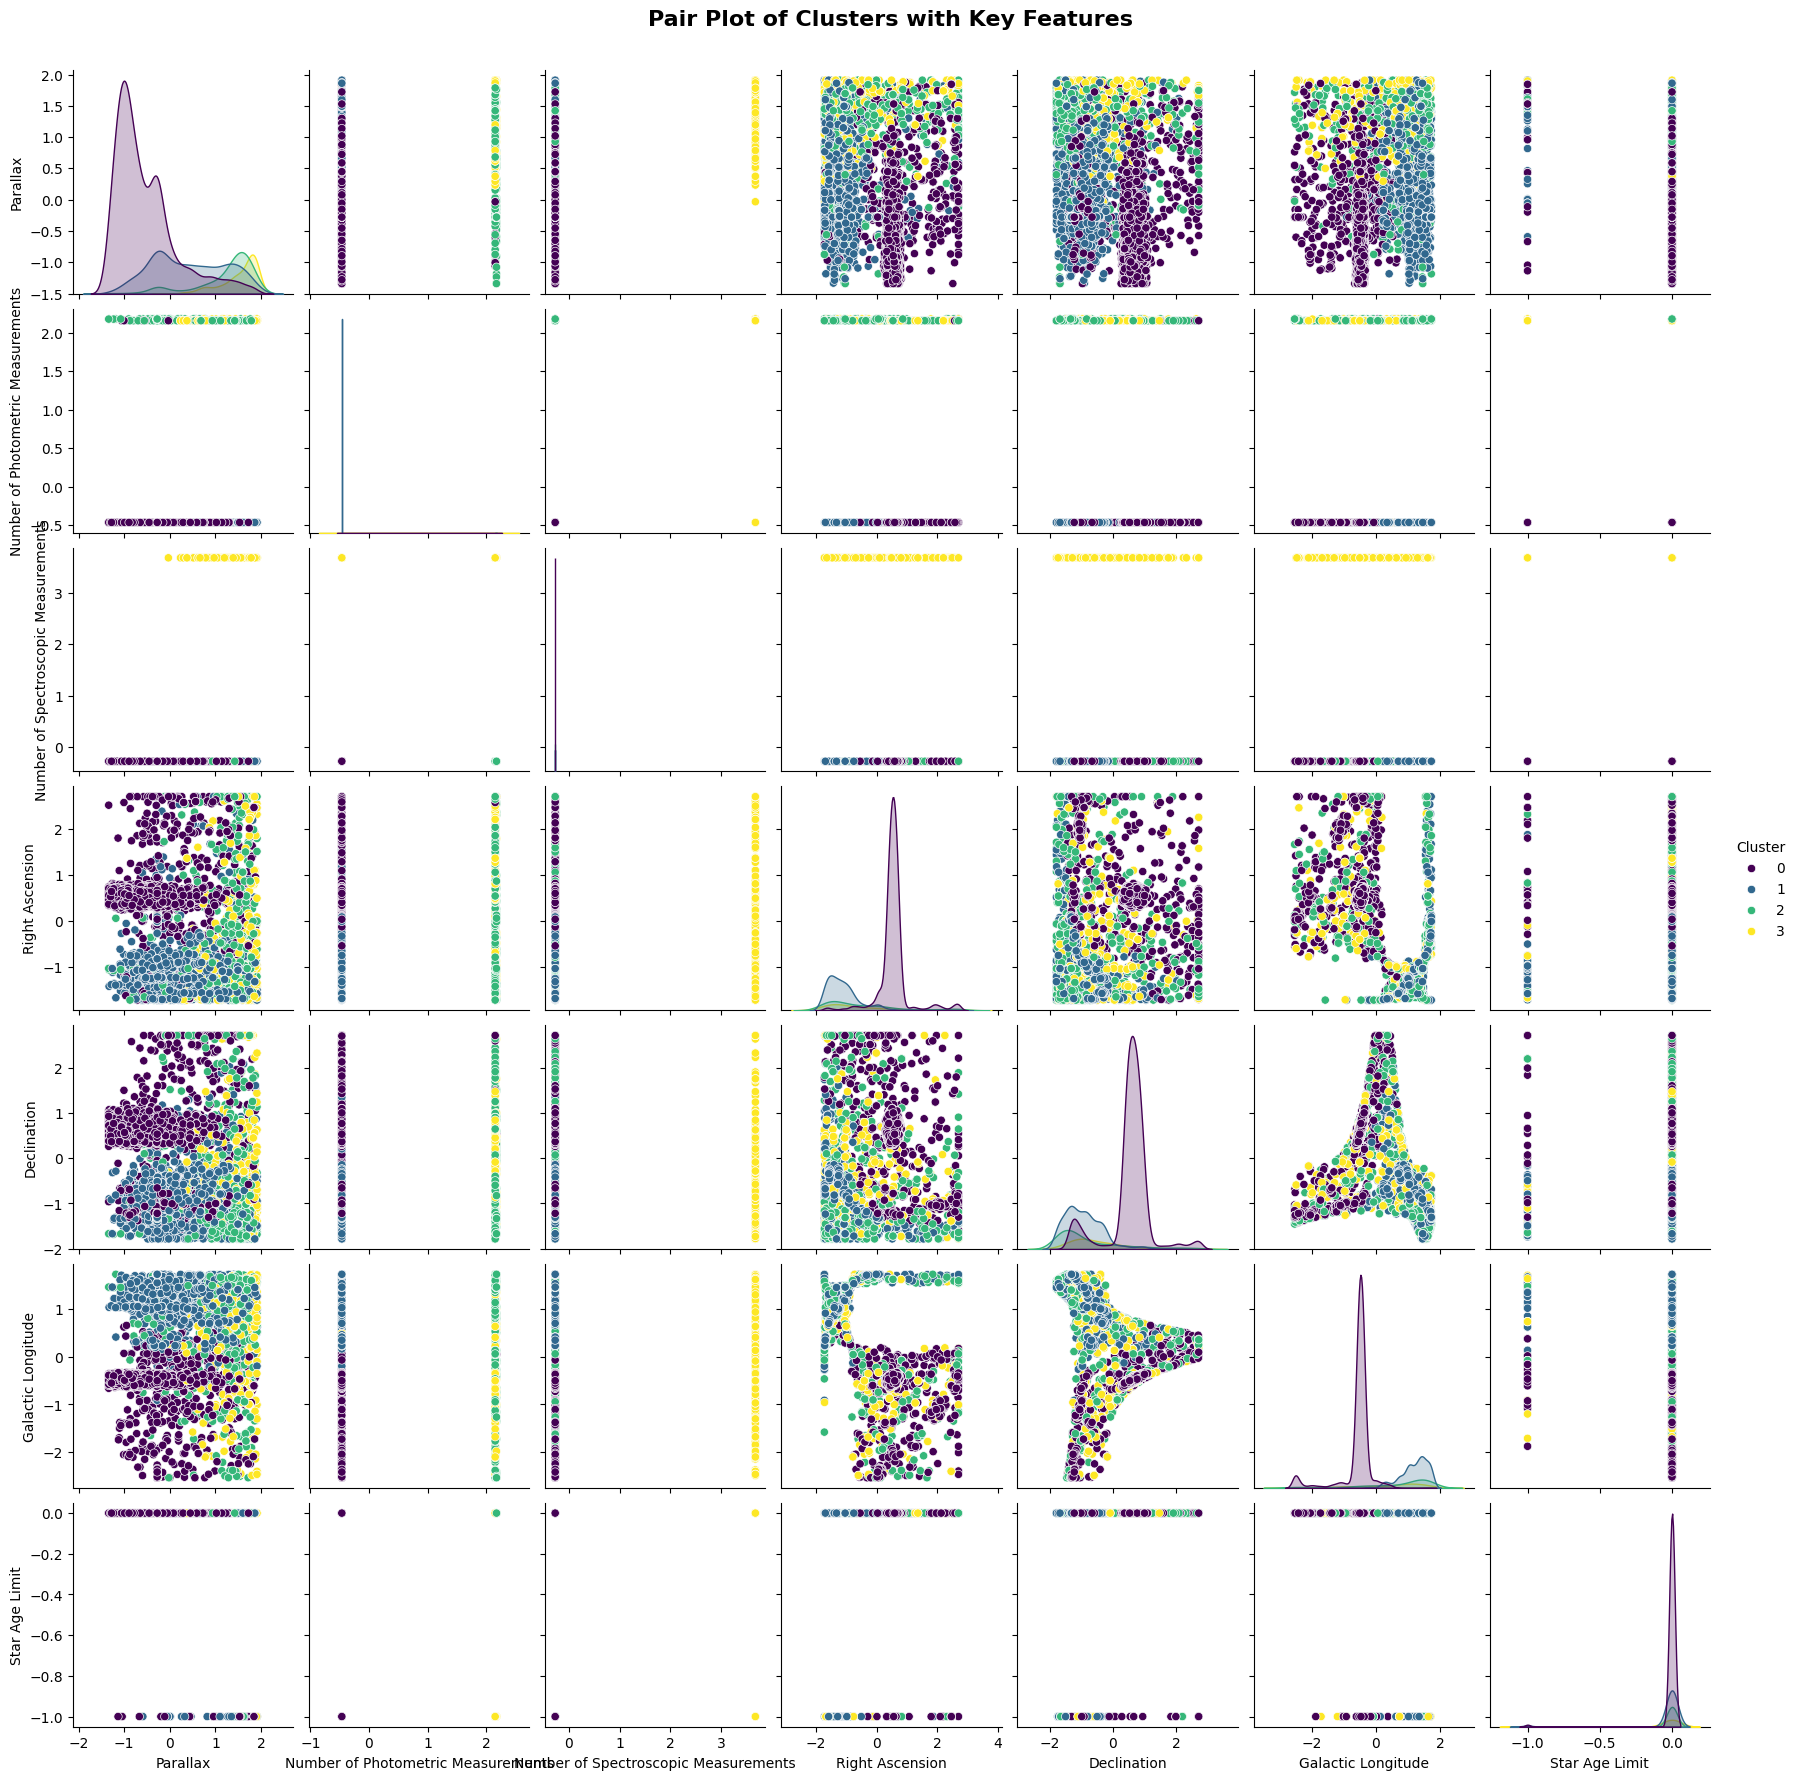

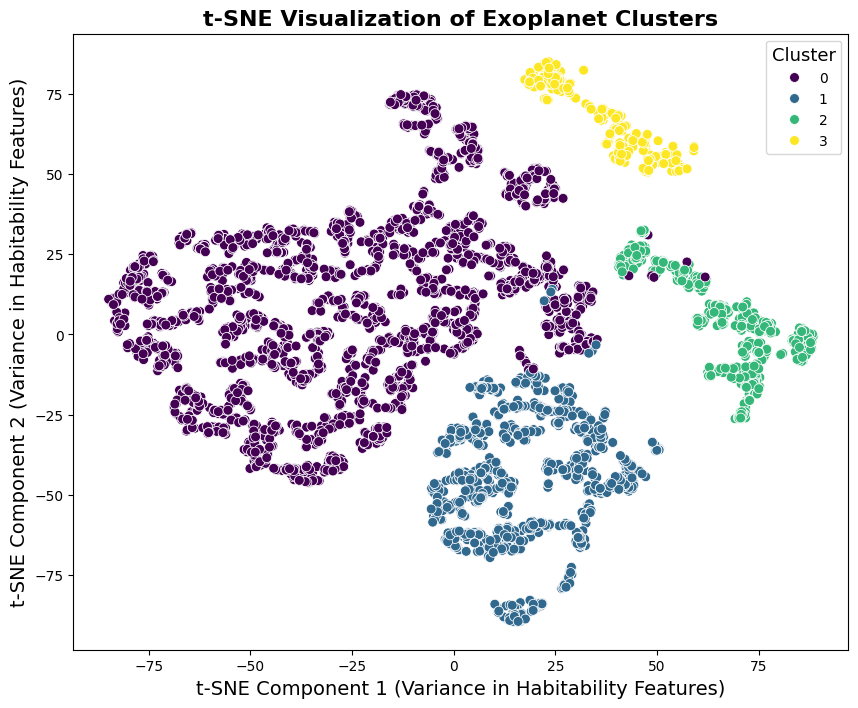

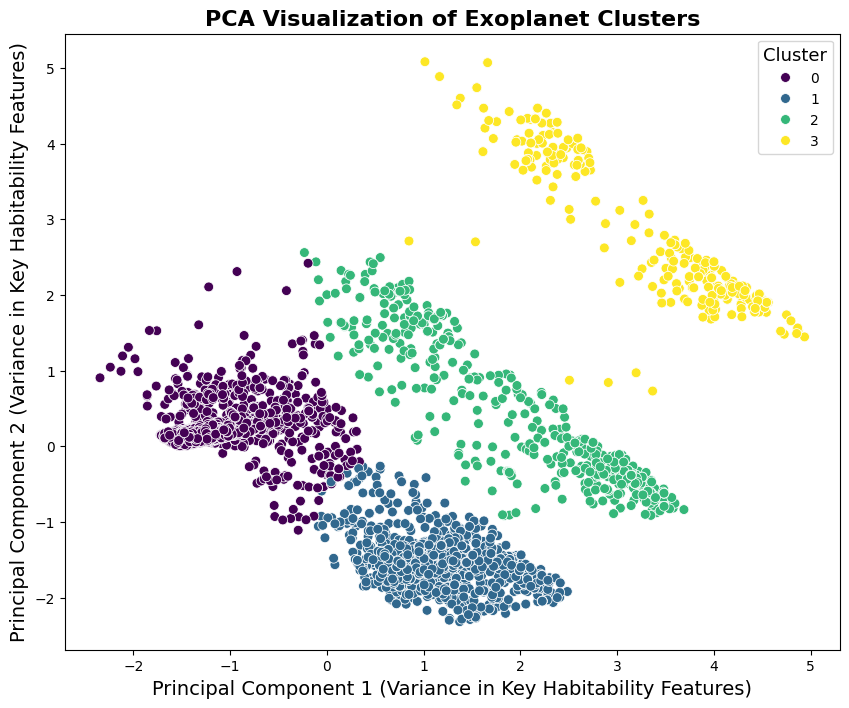

Mean values of features for each cluster:
         Parallax  Number of Photometric Measurements  \
Cluster                                                 
0       -0.544521                           -0.454423   
1        0.414820                           -0.463491   
2        1.195835                            2.158123   
3        1.519301                            2.084334   

         Number of Spectroscopic Measurements  Right Ascension  Declination  \
Cluster                                                                       
0                                   -0.272178         0.544324     0.526213   
1                                   -0.272178        -1.065431    -0.920524   
2                                   -0.272178        -0.474585    -0.737365   
3                                    3.674064        -0.532119    -0.434706   

         Galactic Longitude  Star Age Limit  
Cluster                                      
0                 -0.592393       -0.009516  
1 

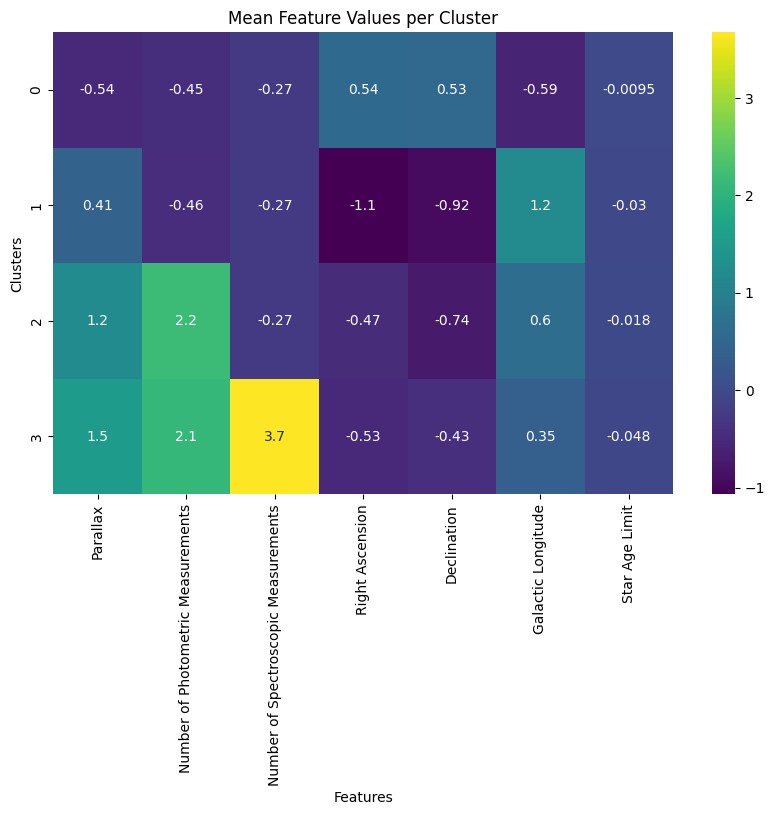

In [9]:
# Execute visualizations
plot_pairwise_clusters(best_feature_set)
tsne_visualization(best_feature_set)
pca_visualization(best_feature_set)

# Calculate the mean values of features for each cluster
cluster_means = best_feature_set.groupby('Cluster').mean(numeric_only=True)

# Display the mean values for each cluster
print("Mean values of features for each cluster:")
print(cluster_means)

# Visualize values for cluster using heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, annot=True, cmap='viridis')
plt.title('Mean Feature Values per Cluster')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()


In [10]:
# Create a DataFrame to hold features for each cluster
cluster_summary = {}

# Iterate through each cluster to find the features
for cluster in best_feature_set['Cluster'].unique():
    features_in_cluster = cluster_means.loc[cluster].sort_values(ascending=False)
    top_features = features_in_cluster.head(3)
    bottom_features = features_in_cluster.tail(3)
    cluster_summary[cluster] = {
        'Top Features': top_features.index.tolist(),
        'Top Values': top_features.round(2).values.tolist(),
        'Bottom Features': bottom_features.index.tolist(),
        'Bottom Values': bottom_features.round(2).values.tolist(),
    }

# Display the cluster summary
for cluster, features in cluster_summary.items():
    print(f"Cluster {cluster}:")
    print("  Top Features:")
    for feat, value in zip(features['Top Features'], features['Top Values']):
        print(f"    - {feat}: {value:.2f}")
    print("  Bottom Features:")
    for feat, value in zip(features['Bottom Features'], features['Bottom Values']):
        print(f"    - {feat}: {value:.2f}")

# Save the labeled DataFrame to a new CSV file
labeled_df_filename = 'labeled_cluster_exoplanet_data.csv'
best_feature_set.to_csv(labeled_df_filename, index=False)
print(f"Labeled DataFrame saved as {labeled_df_filename}")

Cluster 2:
  Top Features:
    - Number of Photometric Measurements: 2.16
    - Parallax: 1.20
    - Galactic Longitude: 0.60
  Bottom Features:
    - Number of Spectroscopic Measurements: -0.27
    - Right Ascension: -0.47
    - Declination: -0.74
Cluster 3:
  Top Features:
    - Number of Spectroscopic Measurements: 3.67
    - Number of Photometric Measurements: 2.08
    - Parallax: 1.52
  Bottom Features:
    - Star Age Limit: -0.05
    - Declination: -0.43
    - Right Ascension: -0.53
Cluster 0:
  Top Features:
    - Right Ascension: 0.54
    - Declination: 0.53
    - Star Age Limit: -0.01
  Bottom Features:
    - Number of Photometric Measurements: -0.45
    - Parallax: -0.54
    - Galactic Longitude: -0.59
Cluster 1:
  Top Features:
    - Galactic Longitude: 1.19
    - Parallax: 0.41
    - Star Age Limit: -0.03
  Bottom Features:
    - Number of Photometric Measurements: -0.46
    - Declination: -0.92
    - Right Ascension: -1.07
Labeled DataFrame saved as labeled_cluster_exoplan